4. Classification Analysis: Predicting Market Direction
Project: CryptoGigel

Objective: Instead of predicting the exact price, here we ask a simpler question: Will Bitcoin close HIGHER or LOWER tomorrow?

Task: Binary Classification (0 = Down, 1 = Up). Baseline: A random guess (coin flip) would be 50% accurate. Our goal is to beat 50%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set visual style
sns.set_style("whitegrid")

# Load data (Same processed file as regression)
file_path = '../data/processed/bitcoin_processed.csv'
df = pd.read_csv(file_path, index_col=0)

print("Data loaded for Classification.")

Data loaded for Classification.


2. Target Definition & Class Balance
We define our inputs (X) and output (y).

Target: Target_Direction.

Class Balance Check: We must check if we have roughly the same amount of "Up" days vs "Down" days.

Why? If 90% of days are "Up", a model that always guesses "Up" has 90% accuracy but is useless. We want a balanced dataset.

In [2]:
# Features (Same as Regression context)
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'SMA_7', 'SMA_30', 'Pct_Change', 'Volatility', 'RSI']
X = df[feature_cols]

# Target for CLASSIFICATION (0 = Down, 1 = Up)
y = df['Target_Direction']

print("Target Distribution (Class Balance):")
print(y.value_counts()) 
# Note: Ideally, these numbers should be close (e.g., 500 vs 520).

Target Distribution (Class Balance):
Target_Direction
1    903
0    863
Name: count, dtype: int64


3. Split & Scale
Just like in Regression, we respect the timeline (No Shuffling). We also apply StandardScaler.

Why Scale? Algorithms like SVM (Support Vector Machines) and KNN calculate "distances" between data points. If one feature (Volume) is in billions and another (RSI) is 0-100, the distance calculation breaks without scaling.

In [3]:
# Split data (Shuffle=False is mandatory for Time Series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the data (Crucial for SVM and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"Train size: {len(X_train)} days")
print(f"Test size:  {len(X_test)} days")

Train size: 1412 days
Test size:  354 days


4. Model Selection
We deploy a mix of linear and non-linear classifiers:

Logistic Regression: The baseline linear classifier.

Random Forest: Uses many decision trees to "vote" on the outcome. Good for handling noise.

SVM (RBF Kernel): Draws complex boundaries between classes using vectors.

KNN: Looks at the neighbors (similar past days).

Naive Bayes: Probabilistic approach based on Bayes' Theorem.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "KNN Classifier": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

print("Classification models initialized.")

Classification models initialized.


5. Training Loop
We train each model and measure Accuracy.

Accuracy: (Correct Predictions) / (Total Predictions).

Goal: Anything consistently above 0.50 (50%) is considered "Edge" in financial markets.

In [5]:
results = []

print("Training Classification Models...")

for name, model in models.items():
    # 1. Train
    model.fit(X_train_scaled, y_train)
    
    # 2. Predict
    preds = model.predict(X_test_scaled)
    
    # 3. Score
    acc = accuracy_score(y_test, preds)
    
    results.append({
        "Model": name,
        "Accuracy": acc
    })
    print(f"--> {name}: {acc:.4f}")

# Sort by best performance
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)

Training Classification Models...
--> Logistic Regression: 0.5085
--> Random Forest: 0.5085
--> SVM (RBF Kernel): 0.5000
--> KNN Classifier: 0.4689
--> Naive Bayes: 0.4746


,Model,Accuracy
0,Logistic Regression,0.508475
1,Random Forest,0.508475
2,SVM (RBF Kernel),0.500000
4,Naive Bayes,0.474576
3,KNN Classifier,0.468927


6. Visualization: Can we beat the coin flip?
We visualize the accuracy scores. The Red Line at 0.5 (50%) represents a random guess.

If a bar is below the red line, the model is worse than random chance.

If a bar is above, we have found a signal.

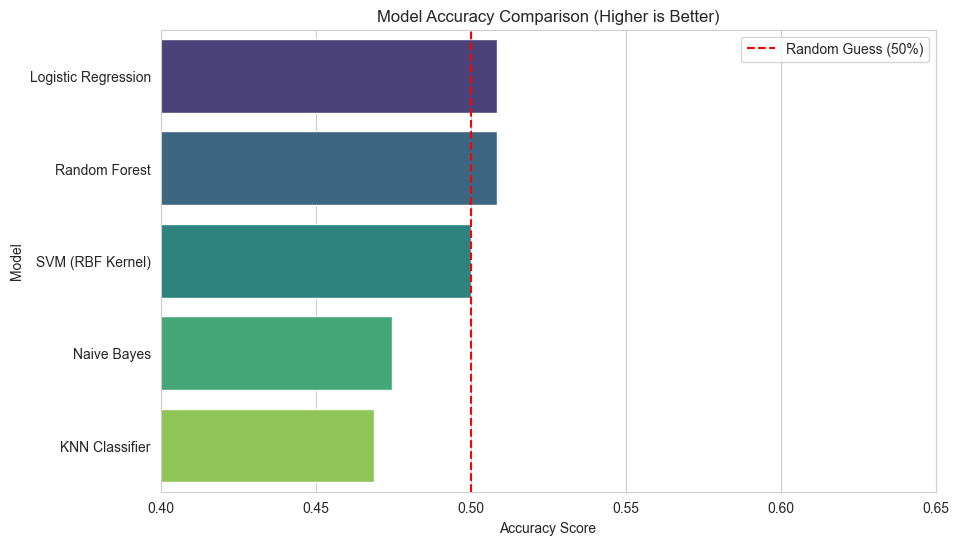

In [6]:
plt.figure(figsize=(10, 6))

# Plot Accuracy
sns.barplot(x="Accuracy", y="Model", data=results_df, hue="Model", palette="viridis", legend=False)

plt.title("Model Accuracy Comparison (Higher is Better)")
plt.xlim(0.4, 0.65) # Zoom in to see the small differences
plt.axvline(0.5, color='red', linestyle='--', label='Random Guess (50%)')
plt.xlabel('Accuracy Score')
plt.legend()
plt.show()

7. Deep Dive: Confusion Matrix
Accuracy isn't everything. We need to know how the model fails.

True Positive (Bottom Right): Predicted UP, Actual UP. (We make money).

False Positive (Top Right): Predicted UP, Actual DOWN. (We lose money - Bad!).

False Negative (Bottom Left): Predicted DOWN, Actual UP. (Missed opportunity).

Analyzing Best Model: Logistic Regression


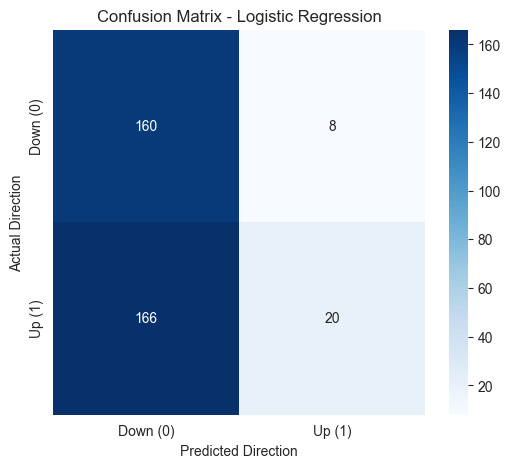

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.95      0.65       168
           1       0.71      0.11      0.19       186

    accuracy                           0.51       354
   macro avg       0.60      0.53      0.42       354
weighted avg       0.61      0.51      0.41       354



In [8]:
# 1. Select Best Model
best_model_name = results_df.iloc[0]['Model']
print(f"Analyzing Best Model: {best_model_name}")

best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train) # Re-fit to be sure
preds = best_model.predict(X_test_scaled)

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down (0)', 'Up (1)'], 
            yticklabels=['Down (0)', 'Up (1)'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Direction')
plt.ylabel('Actual Direction')
plt.show()

# 3. detailed Report
print("Classification Report:")
print(classification_report(y_test, preds))